# inference mode

In [1]:
import numpy as np
import glob
import PIL
import cv2
import sys ,os
import matplotlib.pyplot as plt
%matplotlib inline
import time
os.environ['CUDA_VISIBLE_DEVICES'] = '0' 
import tensorflow as tf
import keras

Using TensorFlow backend.


In [2]:
log_dir = '/home/sdc/github/AdversarialVariationalBayes/experiments/avb_torcs_320/logs2/'
sys.path.append('/home/sdc/github/AdversarialVariationalBayes/')

In [3]:
ls /home/sdc/github/AdversarialVariationalBayes/experiments/avb_torcs_320/logs2/

checkpoint
events.out.tfevents.1508902680.frankwang-Tri01
events.out.tfevents.1509154320.frankwang-Tri01
events.out.tfevents.1509155241.frankwang-Tri01
events.out.tfevents.1509324846.frankwang-Tri01
graph.pbtxt
model.ckpt-494895.data-00000-of-00001.tempstate1795637822235062830
model.ckpt-755745.data-00000-of-00001
model.ckpt-755745.index
model.ckpt-755745.meta
model.ckpt-757013.data-00000-of-00001
model.ckpt-757013.index
model.ckpt-757013.meta
model.ckpt-758278.data-00000-of-00001
model.ckpt-758278.index
model.ckpt-758278.meta
model.ckpt-759544.data-00000-of-00001
model.ckpt-759544.index
model.ckpt-759544.meta
model.ckpt-760809.data-00000-of-00001
model.ckpt-760809.index
model.ckpt-760809.meta


### laod data

In [4]:
file_list = glob.glob('/data/dataset/torcs/log-avb-new/*.jpg')

In [5]:
def np_show(a):
    plt.imshow(a)

def im_read(f):
    return plt.imread(f)

def im_show(f):
    np_show(im_read(f))

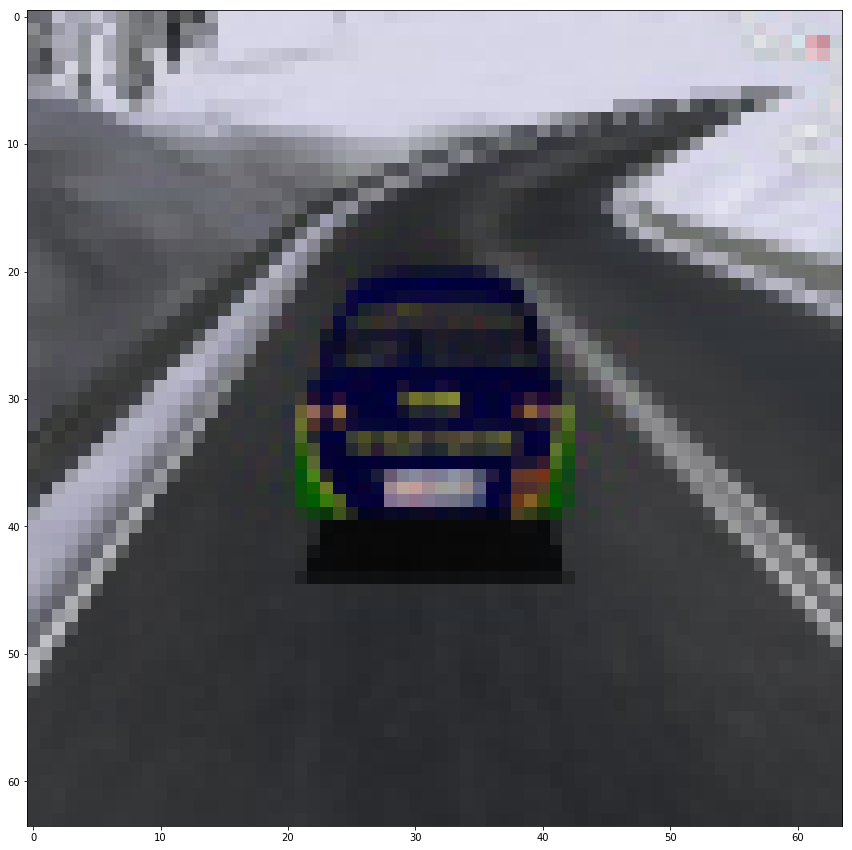

In [6]:
plt.figure(num=3, figsize=(18, 15),)
a = im_read(file_list[0])
a = cv2.resize(a,(64,64))
a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
a = np.reshape(a , (1,) + a.shape)
#a = a/127.5 - 1.
plt.imshow(a[0])

In [24]:
src_img = np.asarray([   cv2.resize(cv2.cvtColor(cv2.imread(i), cv2.COLOR_BGR2RGB),(64,64))/255.  for i in file_list[:16]])


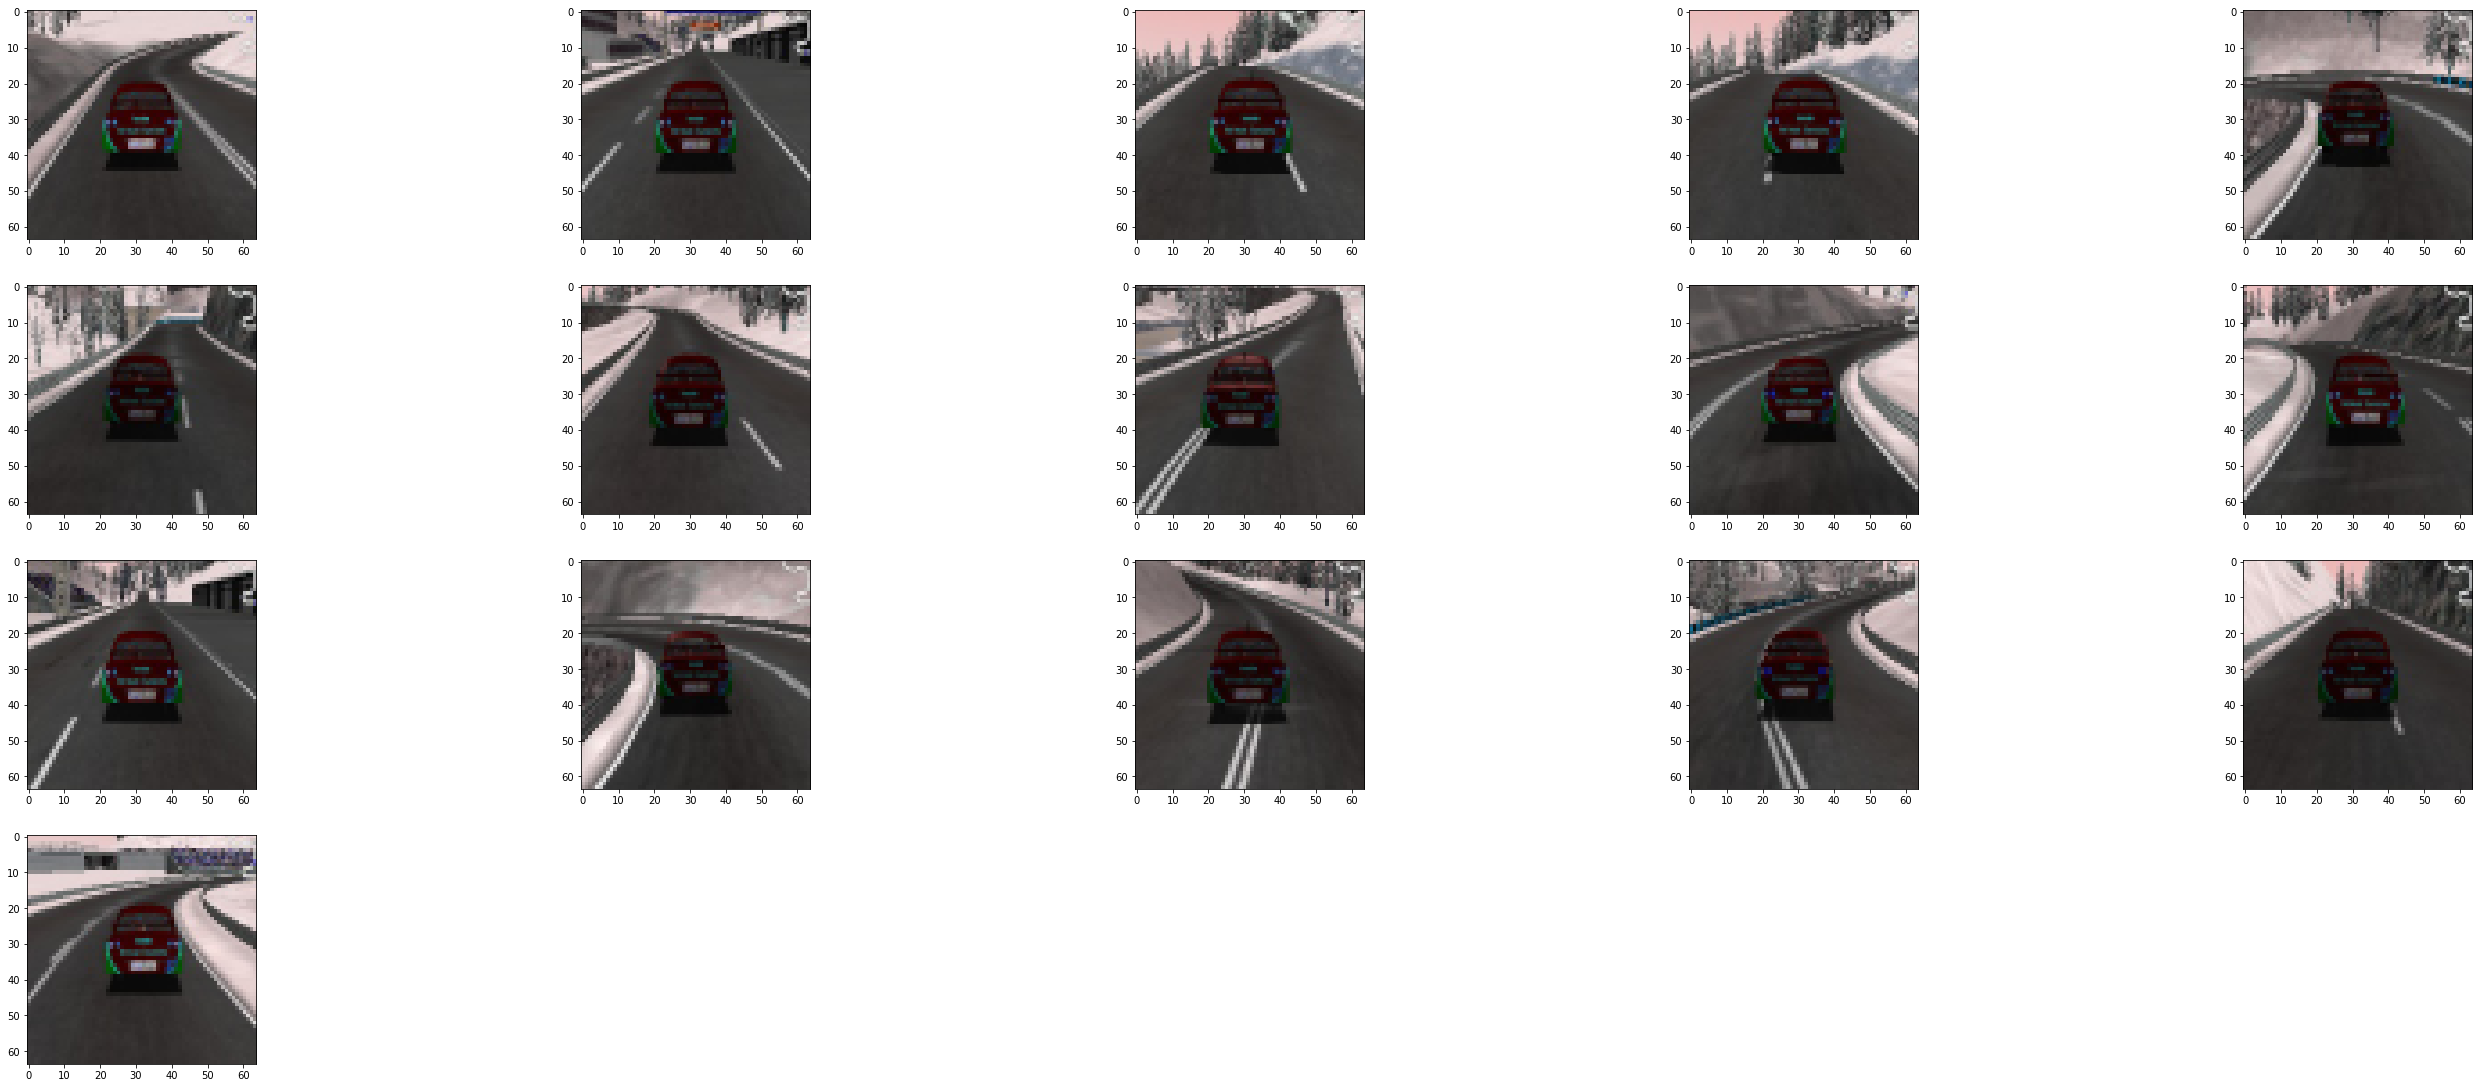

In [25]:
gen = 0.5*(src_img+1.)

plt.figure(num=3, figsize=(48, 75),)
for i in range(len(src_img)):
    plt.subplot(15,5,i+1)
    plt.imshow(src_img[i])

## load  model

####  设置环境变量，设置tf参数
#### 如果不启动tf session ，不用设置config

In [9]:
ckpt = tf.train.latest_checkpoint(log_dir)
model_path = ckpt+'.meta'

In [10]:
config = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
config.gpu_options.allow_growth = True

In [11]:
#build model
from avb import inputs
from avb.decoders import get_decoder
from avb.avb.models import get_encoder, get_adversary
from avb.avb import AVB
from avb.decoders import get_reconstr_err, get_decoder_mean, get_interpolations
avb_config = {}
avb_config['gf_dim'] = 64
avb_config['df_dim'] = 64
avb_config['test_is_adaptive_eps'] = False
avb_config['dataset'] = 'torcs'
avb_config['encoder']= 'conv2'
avb_config['decoder']='conv2'
avb_config['adversary']='conv1'
avb_config['image_size']=128
avb_config['output_size']= 64
avb_config['c_dim']= 3
avb_config['z_dim']= 64
avb_config['z_dist']='gauss'
avb_config['cond_dist']= 'gauss'
avb_config['eps_dim'] = 0
avb_config['eps_nbasis']= 32
avb_config['is_ac'] = False
avb_config['output_size'] = 64

/home/sdc/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [12]:
decoder = get_decoder(avb_config['decoder'], avb_config) #conv2
encoder = get_encoder(avb_config['encoder'], avb_config) #conv2
adversary = get_adversary(avb_config['adversary'], avb_config) #conv1

x_train = tf.placeholder(shape=[None,64,64,3],dtype=tf.float32, name='trainx')
z_sampled = tf.random_normal([64, 64])

In [13]:
avb = AVB(encoder, decoder, adversary, x_train, z_sampled, avb_config, beta=1,is_training=True)

In [14]:
avb.decoder_out[0] ,avb.z_real

(<tf.Tensor 'decoder/x_0/BiasAdd:0' shape=(?, ?, ?, 3) dtype=float32>,
 <tf.Tensor 'encoder/fully_connected/BiasAdd:0' shape=(?, 64) dtype=float32>)

#for empty graph
tf.reset_default_graph()

with tf.Session(config=config) as sess:

    # Restore graph
    saver = tf.train.import_meta_graph(model_path)

    saver.restore(sess, ckpt)

In [15]:
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())
#saver = tf.train.import_meta_graph(model_path)
saver = tf.train.Saver()
saver.restore(sess, ckpt)

INFO:tensorflow:Restoring parameters from /home/sdc/github/AdversarialVariationalBayes/experiments/avb_torcs_320/logs2/model.ckpt-760809


In [16]:
decode_out = get_decoder_mean(avb.decoder_out,None)

In [17]:
z_out = avb.z_real

In [27]:

feed_dict = {x_train : src_img}
decode2 ,z = sess.run([decode_out, z_out],feed_dict =feed_dict)

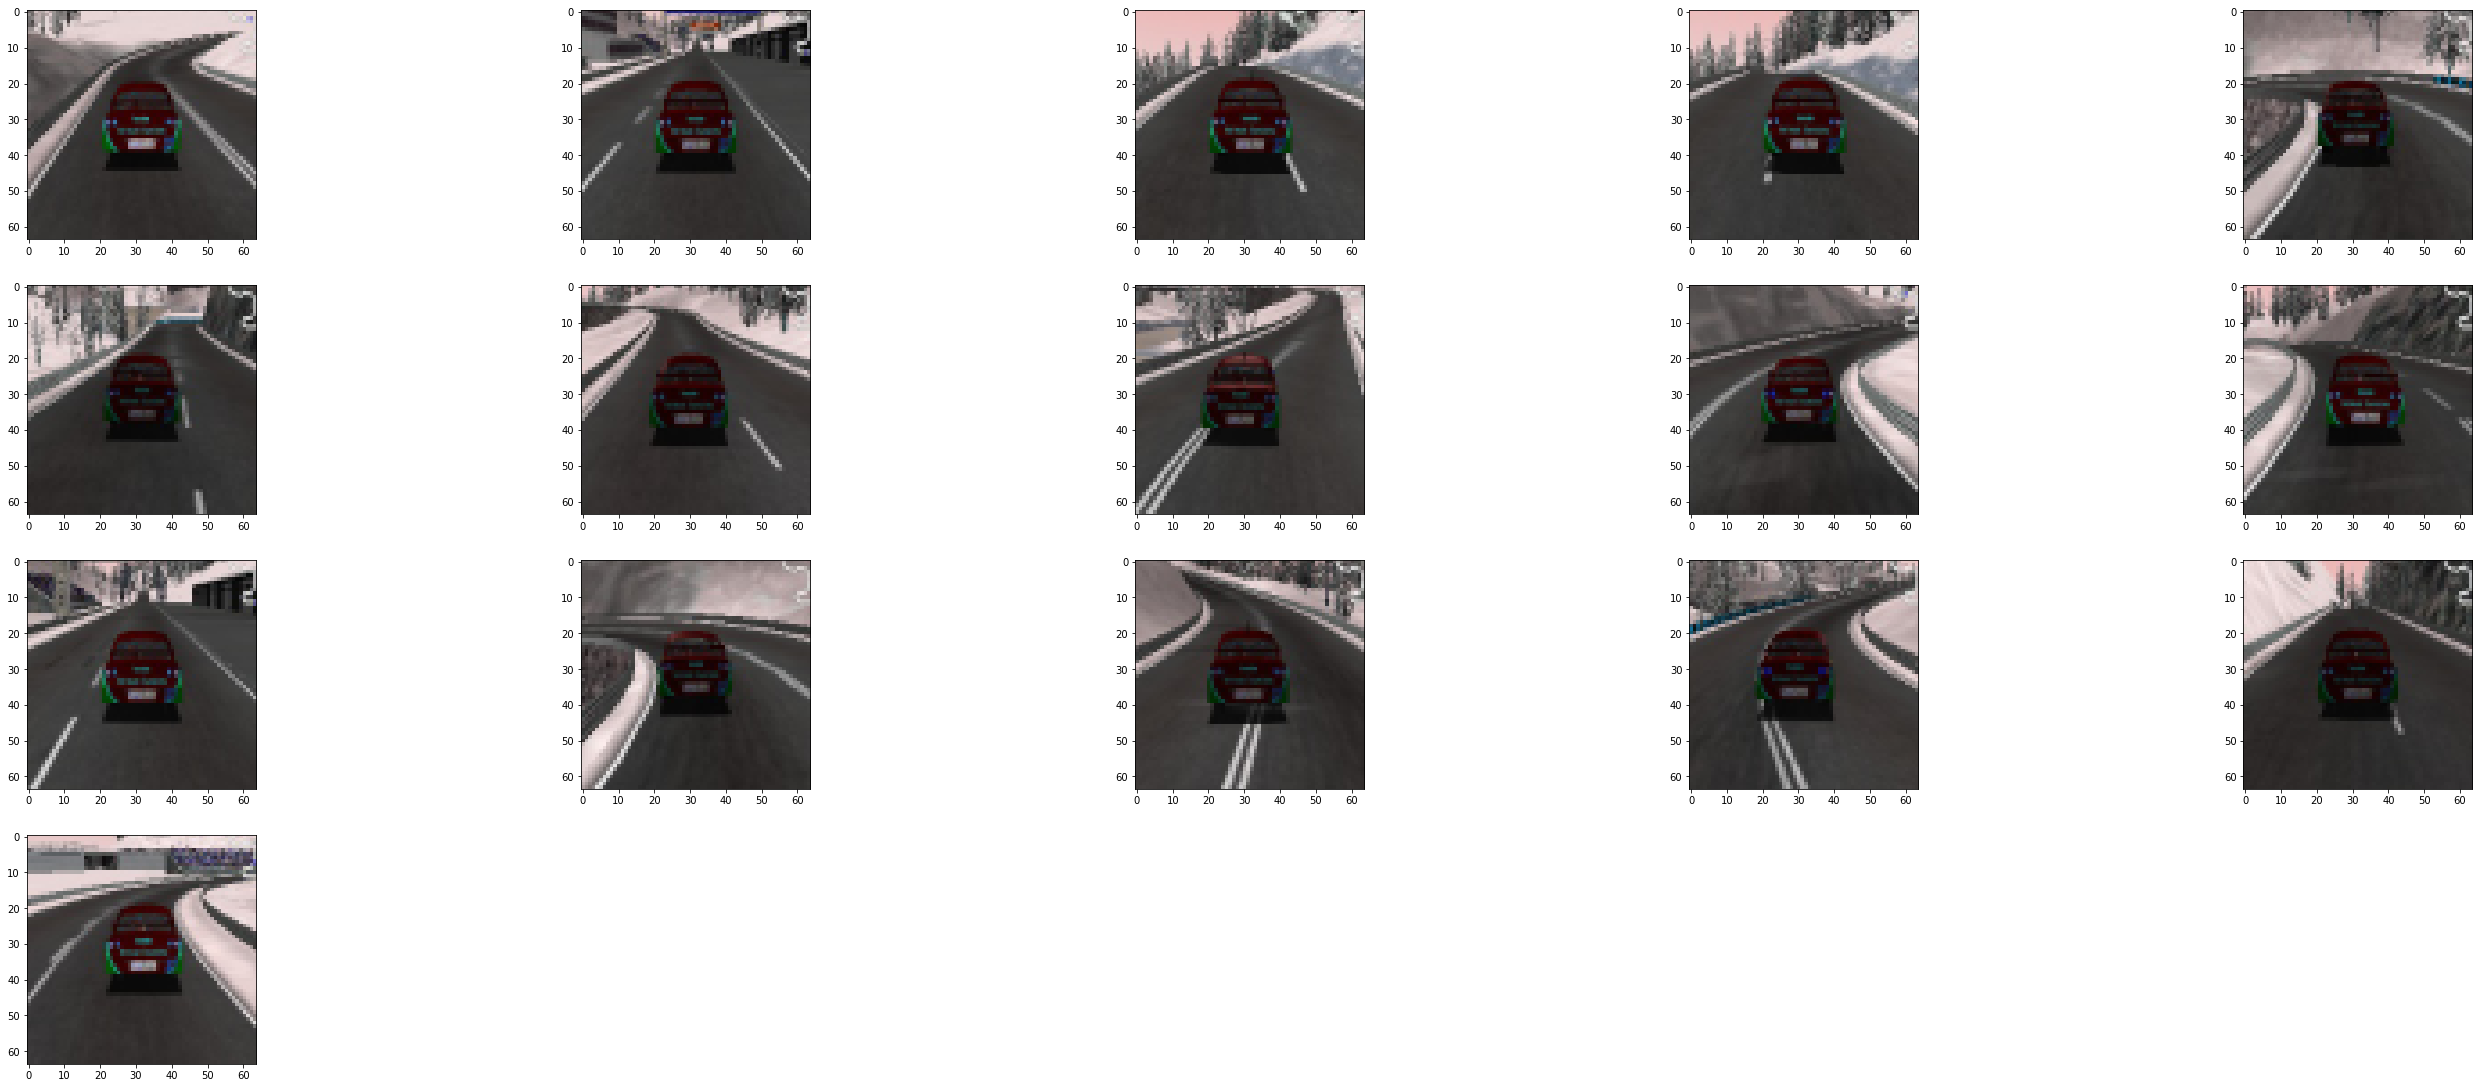

In [28]:

plt.figure(num=3, figsize=(48, 75),)
for i in range(len(src_img)):
    plt.subplot(15,5,i+1)
    plt.imshow(src_img[i])

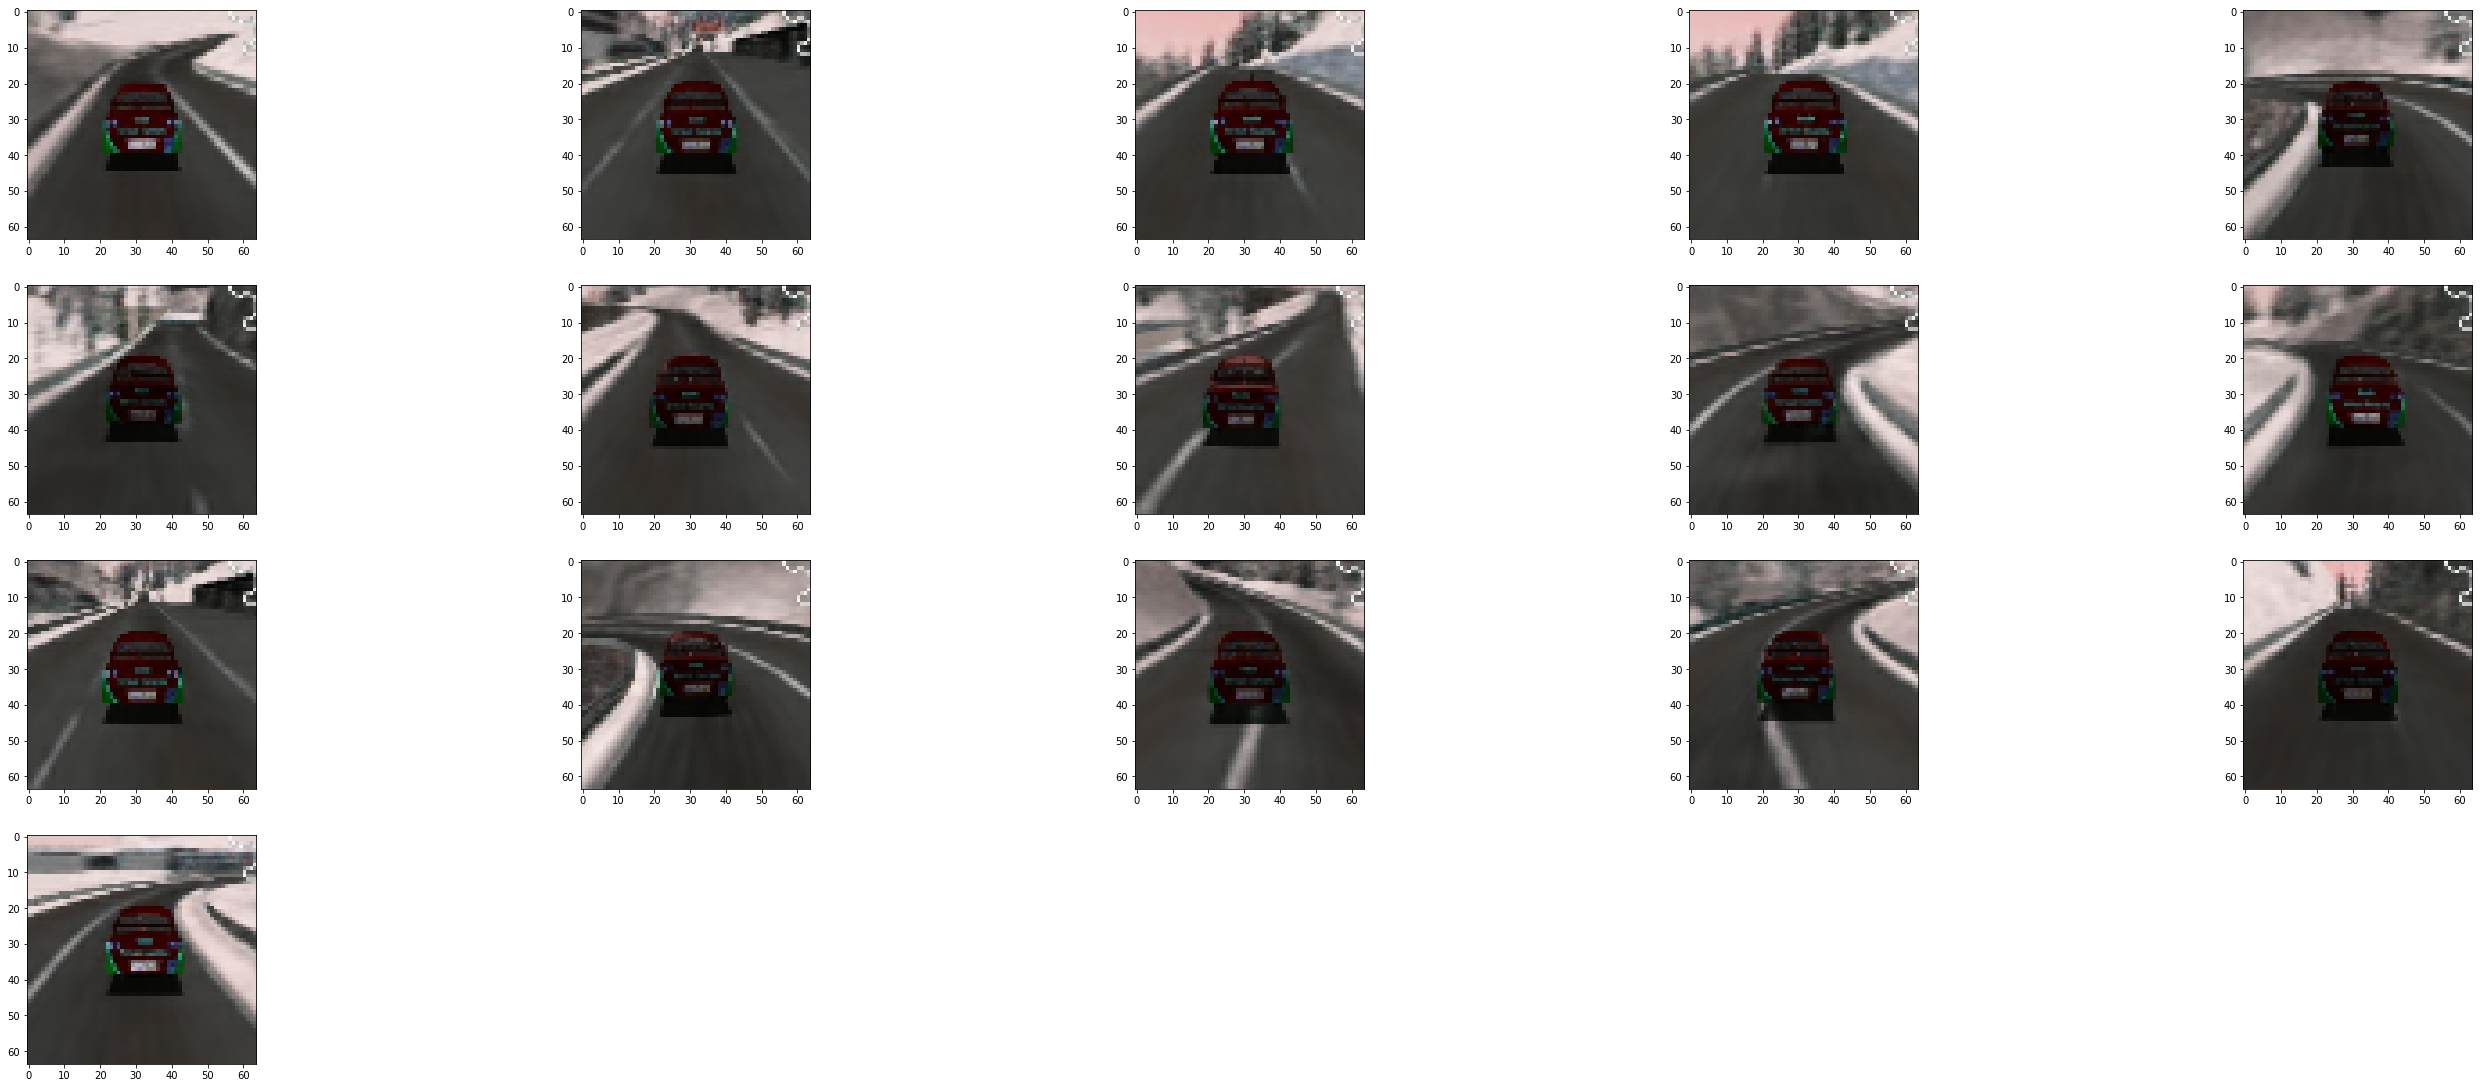

In [29]:

#plt.imshow(decode[1])
#plt.imshow(decode2[1])

plt.figure(num=3, figsize=(48, 75),)
for i in range(len(decode2)):
    plt.subplot(15,5,i+1)
    plt.imshow(decode2[i])

In [30]:
z1 = avb.z_real[:8]
z2 = avb.z_real[8:16]
x_interp = get_decoder_mean(get_interpolations(decoder, z1, z2, 8, avb_config), avb_config)

In [31]:
interp = sess.run(x_interp ,feed_dict=feed_dict)

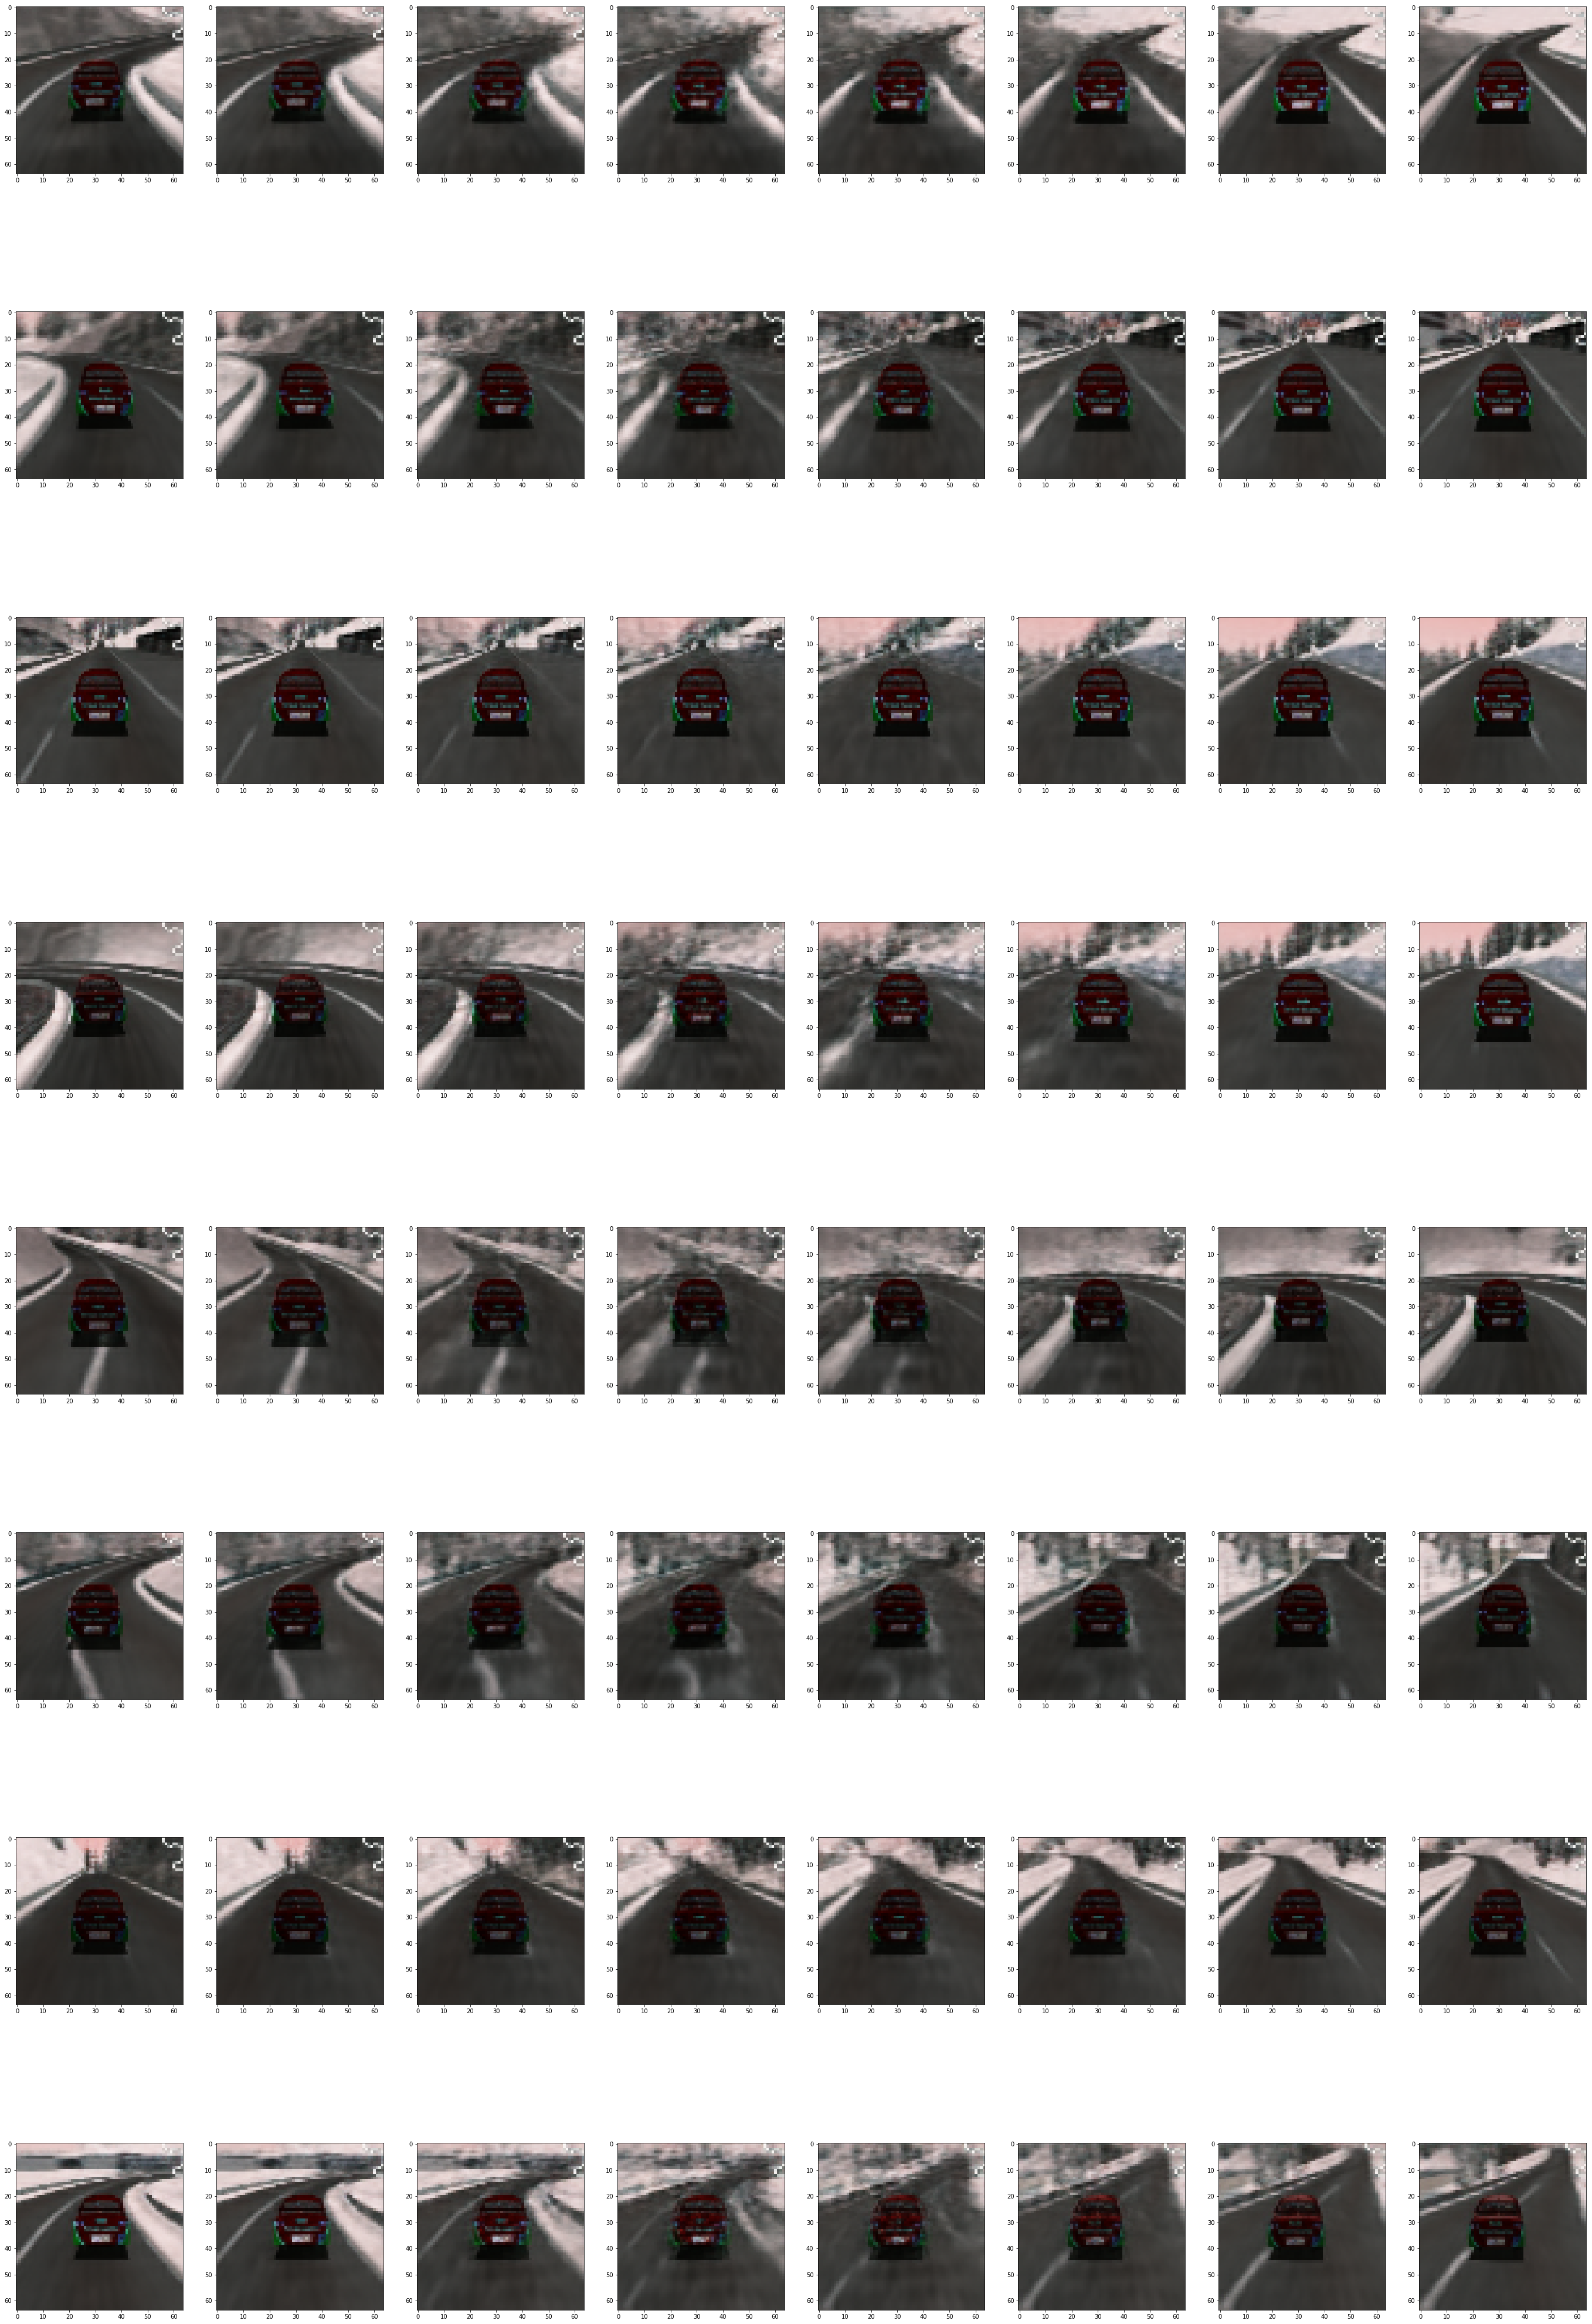

In [32]:

plt.figure(num=3, figsize=(48, 75),)
for i in range(len(interp)):
    plt.subplot(8,8,i+1)
    plt.imshow(interp[i])

### 生成图像

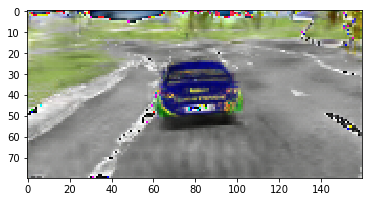

In [90]:
plt.imshow(G_output[0][0])

In [91]:
def cvt_imgs(decode_img ,src_img=None):

    size = decode_img.shape[0]
    N = int(size/8 +2)
    big_img = np.ones([80*8, 160*N, 3], np.float32)
    img_list = [None]*8*N
    for i in list(range(8)):
        img_list[N * i ] = src_img[i+8]
        img_list[N * i  + N - 1] = src_img[i ]

    index = 0
    for i in range(len(img_list)):
        if img_list[i] is   None:
            img_list[i] = decode_img[index][:]
            index +=1
    o_shape = [80,160]
    for i in range(8):
        for j in range(N):
            addimg = img_list[i * N + j][:]
            big_img[i * o_shape[0]:(i + 1) * o_shape[0], j * o_shape[1]:(j + 1) * o_shape[1]] = addimg
    big_img = (big_img + 1.)*255./2.
    big_img_rgb = cv2.cvtColor(big_img, cv2.COLOR_BGR2RGB)
    return big_img_rgb

In [92]:
big_img = cvt_imgs(G_output[0] , src_img )
cv2.imwrite('inference/{}.jpg'.format(int(time.time())),big_img)

True

1509961707

# interplate

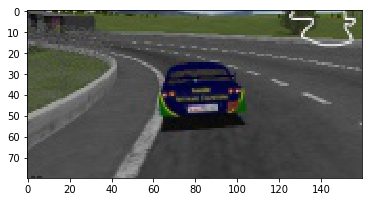

In [293]:
img = src_img[14:15]
plt.imshow(f(img[0])[:,:,::-1])

In [302]:
s = lambda x : x[0] + np.random.normal(0.,1,x[0].shape)*x[1]
f = lambda x : x/2. + 0.5


In [303]:
def change(x, index = 0 , range_ = (0,1), n = 5):
    n = int(n)
    #print(n)
    x = np.repeat(x, n, 0)
    #print(x.shape)
    x[:,index] = x[:,index]+np.linspace(range_[0],range_[1],n)
    return x

In [304]:
def interp(img,**kwargs):
    code = E_predict(img)
    code = s(code)
    code = change(code,**kwargs)
    gen = G_predict(code)[0]
    gen = f(gen)
    return gen

### final

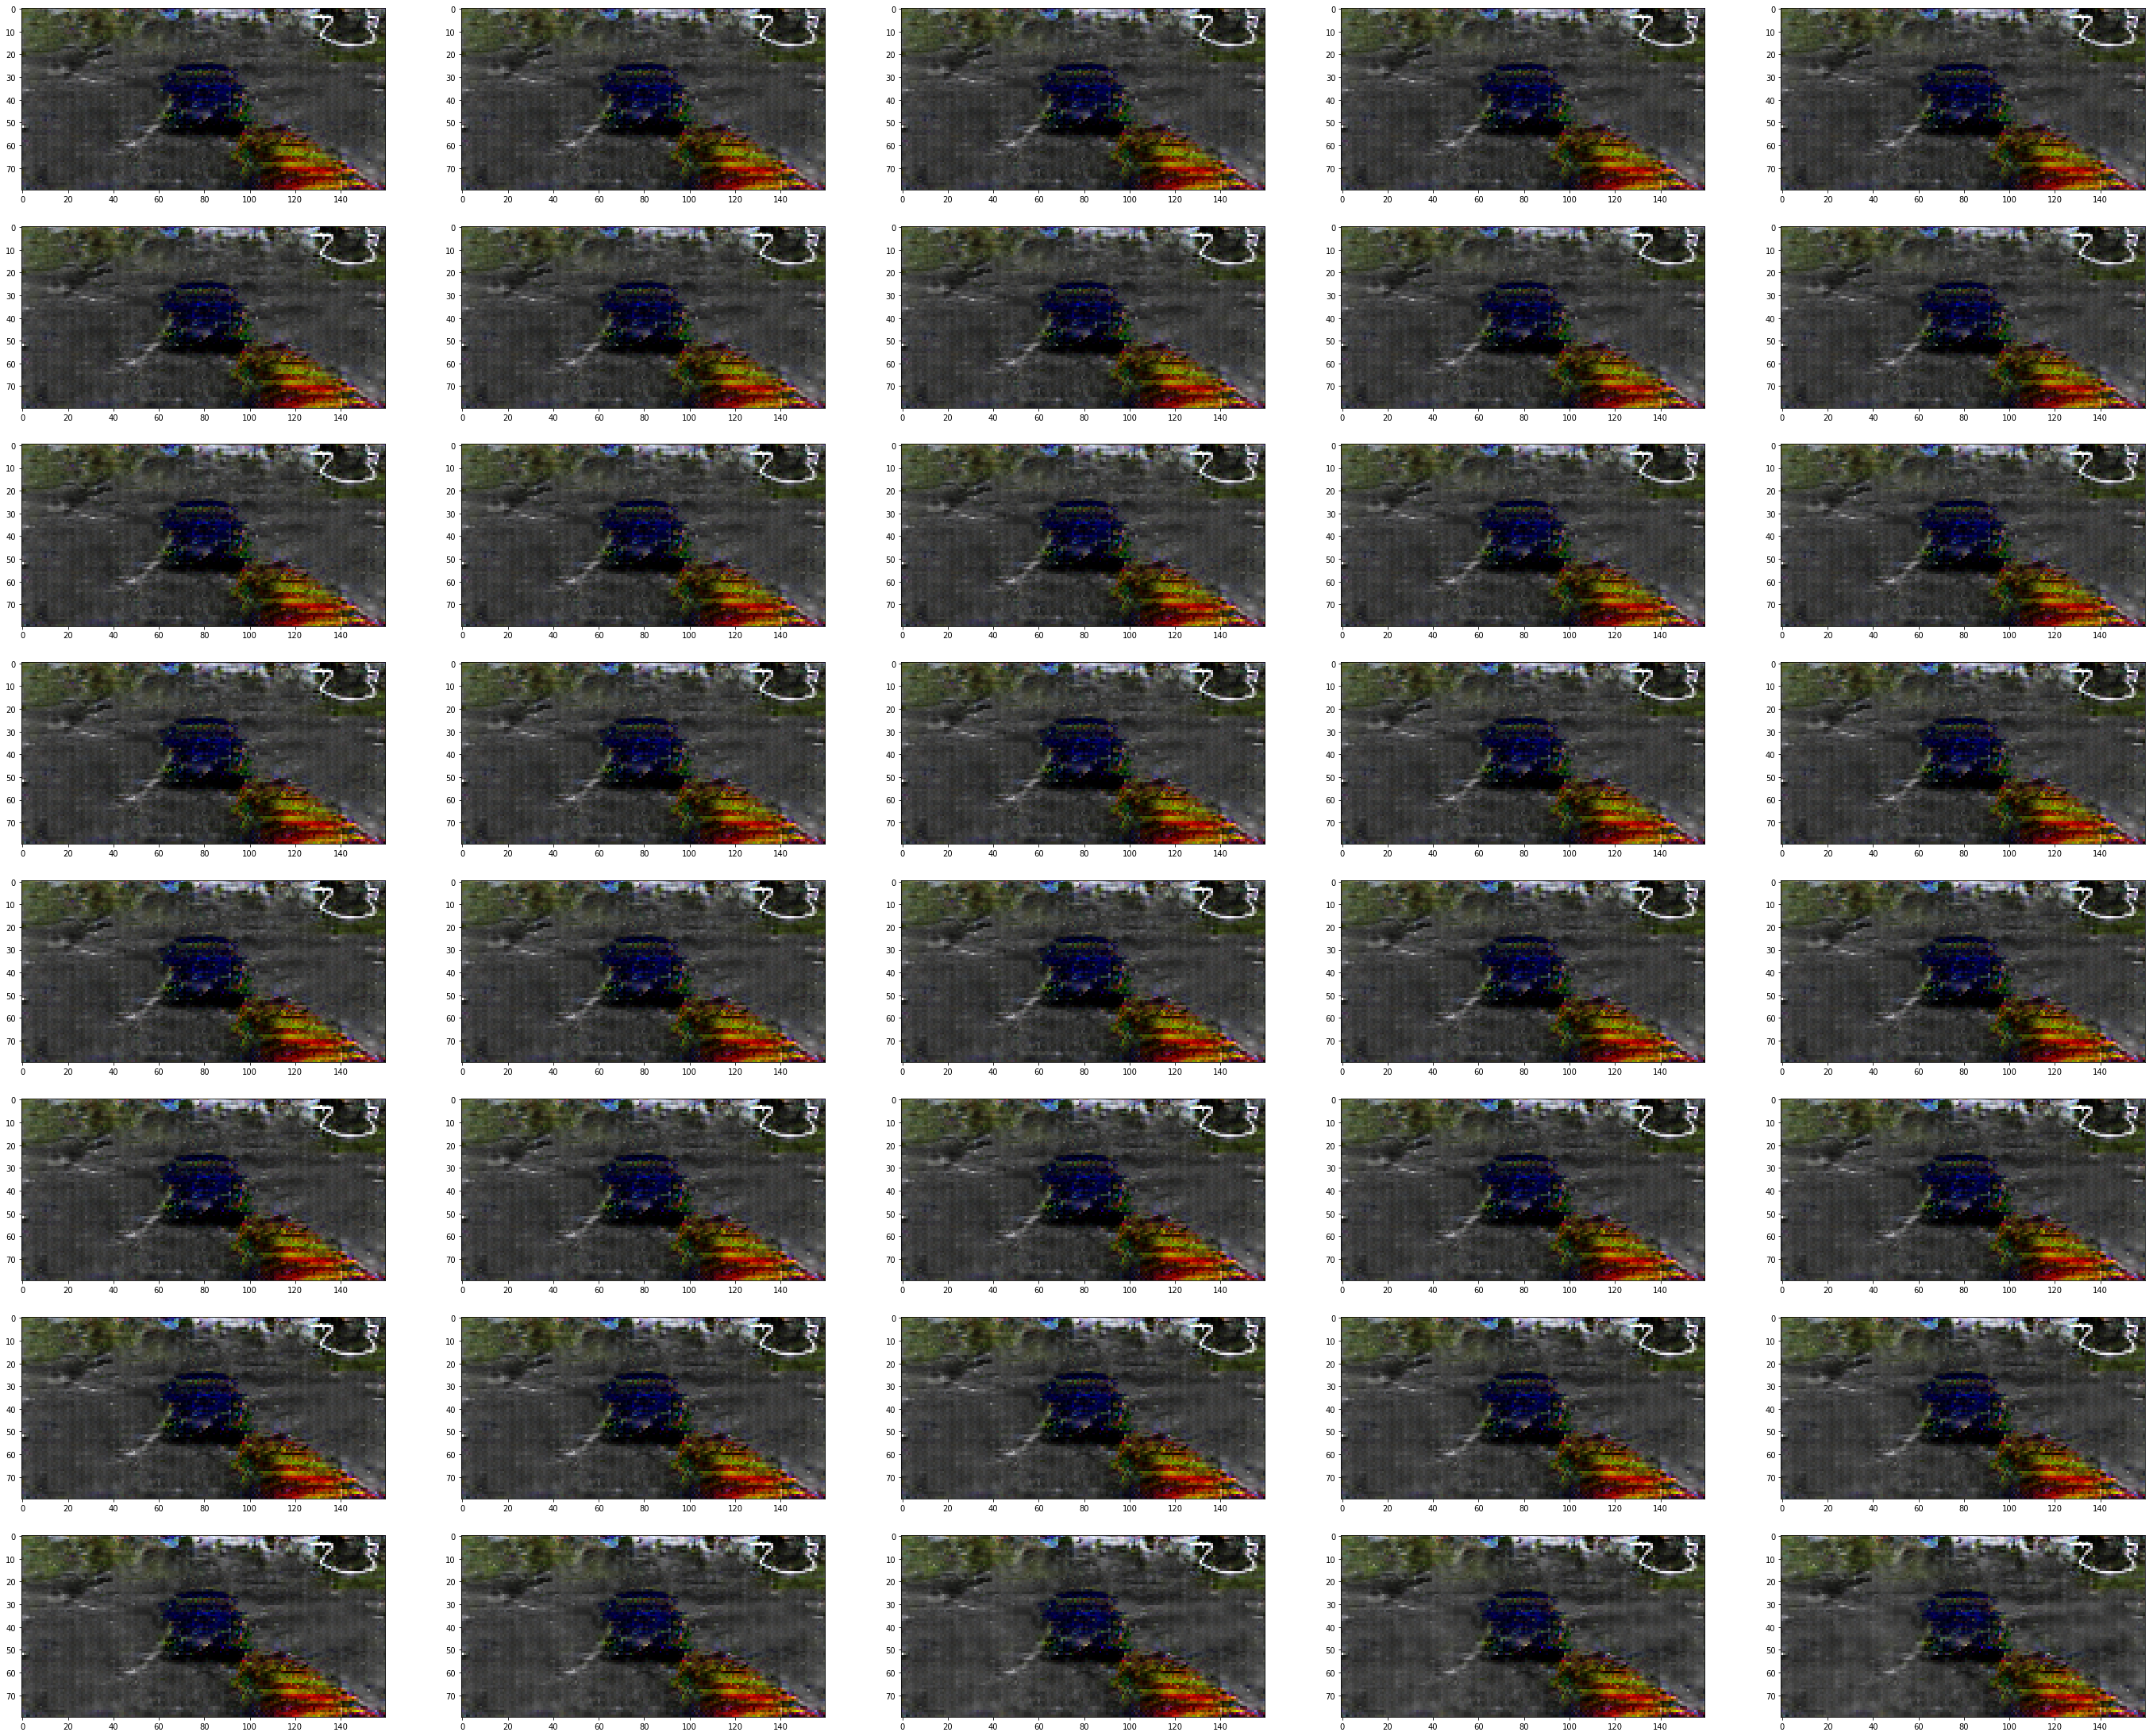

In [311]:
gen = interp(img,index =214, range_ = (-10,50) , n=40)
plt.figure(num=3, figsize=(48, 75),)
for i in range(len(gen)):
    plt.subplot(15,5,i+1)
    plt.imshow(gen[i])

### divide

In [237]:
resize = lambda x :cv2.resize(x , (160,80))
l_img = resize(cv2.imread('l.jpg'))
r_img = resize(cv2.imread('r.jpg'))

In [264]:
img = np.asarray([l_img,r_img])

In [290]:
for i in range(50):
    code = E_predict(img)
    code = s(code)
    v = code[0] - code[1]
    print(v.argmax())

380
351
495
351
196
214
214
214
214
214
196
151
196
196
196
214
380
214
196
214
196
196
380
351
351
214
380
214
196
196
196
254
196
380
196
196
196
351
214
495
196
196
214
380
495
196
214
196
380
214


214